This notebook covers three model implementations:

1. A physics based model based on the Gompertz function
2. To train an LSTM model (data-driven-model) to predict a sequence (e.g., battery capacity over time)
3. To train an LSTM model to predict a sequence (e.g., battery capacity over time) while ensuring it respects physical behavior modeled by the Gompertz function.


## FIXES 

### Fix 1 : Added Sanity Check for val loss and val rmse

Explanation:
Issue	Fix	Why
torch.Tensor()	→ torch.tensor()	The lowercase version is the recommended constructor for creating a single-value tensor.
Missing closing parenthesis	Added	Fixes syntax error.
avg_val_loss type	Ensure it’s a scalar (float or int)	If it’s already a tensor, remove the outer torch.tensor() call.

### Fix 2: Use log loss in calculation of metric charts
### Fix 3: Update reproducibility
### Fix 4: time GPU run

In [1]:

print("# A: Import Libraries and set reproducibility")
# !git clone https://github.com/Yuri-Njathi/battery-lstm-ML.git
# import sys
# sys.path.append("battery-lstm-ML/")


import torch
import numpy as np
import random
import os
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from typing import Callable, Optional

def set_seed(seed=42):
    """
    Set all relevant random seeds to ensure full reproducibility.
    """
    # 1. Set basic seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if multiple GPUs
    
    # 2. Force deterministic behavior in cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # turn off auto-tuning
    
    # 3. Optional: make dataloaders deterministic
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'  # deterministic cublas (for CUDA >= 10.2)

    print(f"✅ Reproducibility environment set with seed = {seed}")

# Call this once at the start, pull from assess
set_seed(42)

'''
set mode i.e.
0 == physics based
1 == lstm (data driven) #SoH only 
2 == lstm (physics constrained)
'''
mode = 1

if mode == 1:
    model_columns = ['SoH']#,'rul','Cycle number']
if mode == 2:
    model_columns = ['SoH','Cycle number','k','a','b']



print("# B: Setup variables and functions")
# # Set variables
# WINDOW_SIZE = 35
model_type = ['lstm','seq2seq-lstm'][0]

cutoff_soh = 0.70
# Set Computing Environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = len(model_columns)
OUTPUT_SIZE =len(model_columns)#1 #controls how many values the lstm outputs
num_epochs = 400 #60
batch_size = 5120 #32
normalize_soh = False
if normalize_soh:
    soh_normalization_constant = 115.0 #115.0 may be better as it allows bounding between 0 and 1
    cutoff_soh = cutoff_soh/soh_normalization_constant #set cutoff soh wrt to normalizer
else:
    soh_normalization_constant = 1.0
    cutoff_soh = cutoff_soh/soh_normalization_constant #set cutoff soh wrt to normalizer

print("Cutoff SoH : ",cutoff_soh)

def df_to_X_y_tensor(df, window_size=5,output_size=5):
    '''
    Converts a time series into (X, y) tensors for LSTM training.
    
    X shape: (num_samples, window_size, 1)
    y shape: (num_samples, 1)
    '''
    if isinstance(df, (pd.DataFrame, pd.Series)):
        df_as_np = df.to_numpy()
    else:
        df_as_np = df  # Assume already numpy

    X, y = [], []
    for i in range(len(df_as_np) - window_size):
        X.append([[val] for val in df_as_np[i:i+window_size]])
        #y.append([df_as_np[i + window_size:i + window_size+output_size]])
        y.append([[val] for val in df_as_np[i + window_size:i + window_size+1]]) #next cycle
    X,y = np.array(X),np.array(y)
    X_tensor = torch.tensor(X, dtype=torch.float32)#.squeeze()
    y_tensor = torch.tensor(y, dtype=torch.float32)#.squeeze()
    return X_tensor, y_tensor

def get_x_y_lists(paths):
    X_list,y_list = [],[]
    for path in paths:
        print(path)
        df = pd.read_csv(path)
        df['Cycle number'] = df['Cycle number']/10000
        df['rul'] = df['rul']
        #normalize SoH
        df['SoH'] =  df['SoH']/soh_normalization_constant
        df.index = df['Cycle number']
        SoH = df[model_columns]
        X, y = df_to_X_y_tensor(SoH, window_size=WINDOW_SIZE,output_size=OUTPUT_SIZE)
        X_list.append(X)
        y_list.append(y)
    return X_list,y_list

def give_paths_get_loaders(paths,data_type,shuffle=False):
    X_list, y_list = get_x_y_lists(paths)

    if INPUT_SIZE == 1:
        # Concatenate all X and y
        X_1,y_1 = torch.cat(X_list, dim=0).squeeze(-1),torch.cat(y_list, dim=0).view(-1,INPUT_SIZE)
    else:
        X_1,y_1 = torch.cat(X_list, dim=0), torch.cat(y_list, dim=0)#.view(-1, OUTPUT_SIZE)
    
    print(f"X_{data_type} , y_{data_type} shapes : ",X_1.shape, y_1.shape)
    
    #DataLoader
    print("load : ")
    loader = DataLoader(TensorDataset(X_1, y_1), batch_size=32, shuffle=shuffle)
    print(f"{data_type}loader lengths : ",loader.__len__())
    return loader,X_1,y_1



print("## 🧠 Model Architecture")
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, mid_size, output_size):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.relu = nn.ReLU()
#         self.fc1 = nn.Linear(hidden_size, mid_size)
#         self.fc2 = nn.Linear(mid_size, output_size)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         last_out = out[:, -1, :]
#         mid = self.relu(self.fc1(last_out))
#         return self.fc2(mid)
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=5):
        super(LSTMModel, self).__init__()
        
        # LSTM: input_size=5 match your features
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Linear Layer: Maps hidden_size (64) -> output_size (5)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [32, 10, 5]
        
        # Run LSTM
        # lstm_out shape: [32, 10, 64]
        lstm_out, _ = self.lstm(x)
        
        # Take the last time step only
        last_time_step = lstm_out[:, -1, :] 
        # last_time_step shape: [32, 64]
        
        # Project to 5 output features
        prediction = self.fc(last_time_step)
        # prediction shape: [32, 5]
        
        return prediction
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, mid_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_size, mid_size)
        self.fc2 = nn.Linear(mid_size, output_size)

    def forward(self, x):
        # out: [batch_size, seq_len, hidden_size]
        out, _ = self.lstm(x)

        # Apply the linear layers to each timestep
        mid = self.relu(self.fc1(out))   # shape: [batch, seq_len, mid_size]
        out_seq = self.fc2(mid)          # shape: [batch, seq_len, output_size]

        return out_seq


    #on initial tensorflow experiments I used 1,64,1,1 for those values.

### TEST ON SEQUENTIAL MODEL ###
# model(torch.Tensor([[86.4707],[86.4150],[86.3590],[86.3035],[86.2506],[86.2512],[86.1954],[86.1403],[86.1427],[86.0904],[86.0373],[85.9772],[85.9743],[85.9198],[85.8654],[85.8090],[85.8077],[85.7524],[85.6986],[85.6407],[85.5883],[85.5882],[85.6112],[85.4756],[85.4753],[85.4187],[85.3639],[85.3086],[85.3098],[85.3628],[85.1723],[85.1430],[85.1444],[85.0896],[85.0364]]))

# A: Import Libraries and set reproducibility
✅ Reproducibility environment set with seed = 42
# B: Setup variables and functions
Cutoff SoH :  0.7
## 🧠 Model Architecture


#### “Normalization” ≠ “scaling to [0,1]”.

#### It simply means rescaling values to a stable, comparable numerical range.

# C: Setup Train, Val and Test Loaders
# 0. Data

Each `X_train` is of shape `(num_samples, window_size)`

Each `y_train` is of shape `(num_samples,)` (usually next value prediction)

##  🧰 Convert to Tensors for LSTM
LSTM expects input shape: (batch_size, sequence_length, num_features)

Let’s reshape the data and convert it:

In [2]:
import re

In [3]:
WINDOW_SIZES = [100]#[5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100,500,1000] #[i for i in range (5,100,5)]
print("WINDOW SIZES TO TEST : ",WINDOW_SIZES,len(WINDOW_SIZES))


# Make list of CSV paths
main_files_path = '/kaggle/input/generate-hust-data-gompertz-k-a-b/'
#/kaggle/input/generate-hust-data-gompertz-k-a-b/1-2-hust_gompertz_params.csv
csv_files = os.listdir(main_files_path)
csv_files = [f for f in csv_files if re.match(r'^\d', f) and f.endswith('-hust_gompertz_params.csv')]

#BatteryML like train-val-test split
csv_files = [f.removesuffix('-hust_gompertz_params.csv') for f in csv_files]
print(csv_files)

train_ids = [
    '1-3',  '1-4',  '1-5',  '1-6',  '1-7',  '1-8',  '2-2',  '2-3',
    '2-4',  '2-6',  '2-7',  '2-8',  '3-2',  '3-3',  '3-4',  '3-5',
    '3-6',  '3-7',  '3-8',  '4-1',  '4-2',  '4-3',  '4-4',  '4-6',
    '4-7',  '4-8',  '5-1',  '5-2',  '5-4',  '5-5',  '5-6',  '5-7',
    '6-3',  '6-4',  '6-5',  '7-1',  '7-2',  '7-3',  '7-4',  '7-7',
    '7-8',  '8-2',  '8-3',  '8-4',  '8-7',  '9-1',  '9-2',  '9-3',
    '9-5',  '9-7',  '9-8',  '10-2', '10-3', '10-5', '10-8']

test_ids = [f for f in csv_files if f not in train_ids]

print(test_ids,len(test_ids))

#csv_paths = [os.path.join(main_files_path, file) for file in csv_files]
#separate according to train, val and test
train_paths = [os.path.join(main_files_path, file+'-hust_gompertz_params.csv') for file in train_ids]

testing_paths = [os.path.join(main_files_path, file+'-hust_gompertz_params.csv') for file in test_ids]

val_paths = testing_paths[:int(len(testing_paths)*0.5)]
test_paths = testing_paths[int(len(testing_paths)*0.5):]

print(len(train_paths), len(val_paths), len(test_paths))

WINDOW SIZES TO TEST :  [100] 1
['6-6', '8-7', '8-6', '9-1', '10-1', '6-8', '8-8', '10-7', '3-5', '5-1', '5-5', '7-1', '2-7', '10-6', '4-7', '7-7', '7-6', '4-5', '9-2', '10-4', '3-1', '9-7', '8-1', '10-8', '8-4', '4-6', '4-4', '3-8', '5-4', '9-6', '10-5', '7-8', '5-2', '9-8', '1-2', '5-6', '10-2', '2-6', '6-1', '2-4', '1-4', '4-1', '1-6', '6-2', '8-5', '5-7', '1-5', '1-8', '5-3', '6-5', '9-5', '4-8', '7-2', '2-5', '7-3', '9-3', '9-4', '8-2', '10-3', '6-3', '3-2', '7-5', '3-7', '2-3', '1-3', '8-3', '2-8', '7-4', '4-2', '6-4', '1-1', '3-3', '4-3', '3-4', '2-2', '1-7', '3-6']
['6-6', '8-6', '10-1', '6-8', '8-8', '10-7', '10-6', '7-6', '4-5', '10-4', '3-1', '8-1', '9-6', '1-2', '6-1', '6-2', '8-5', '5-3', '2-5', '9-4', '7-5', '1-1'] 22
55 11 11


## 🧠 Model
Last model window :  last_model_window_100_model_lstm.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-hust_gompertz_params.csv
/kaggle

<ipython-input-4-1e567a16e933>:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


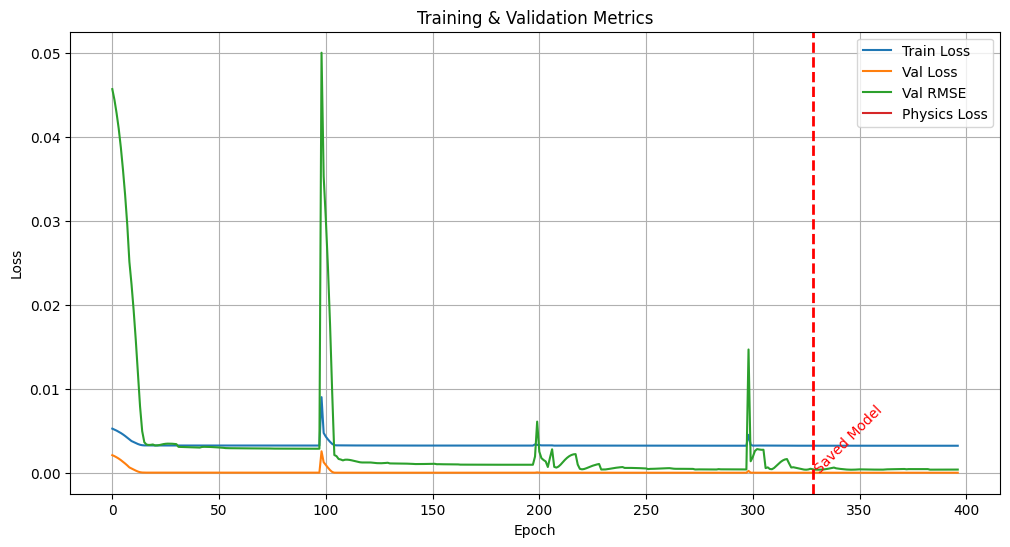

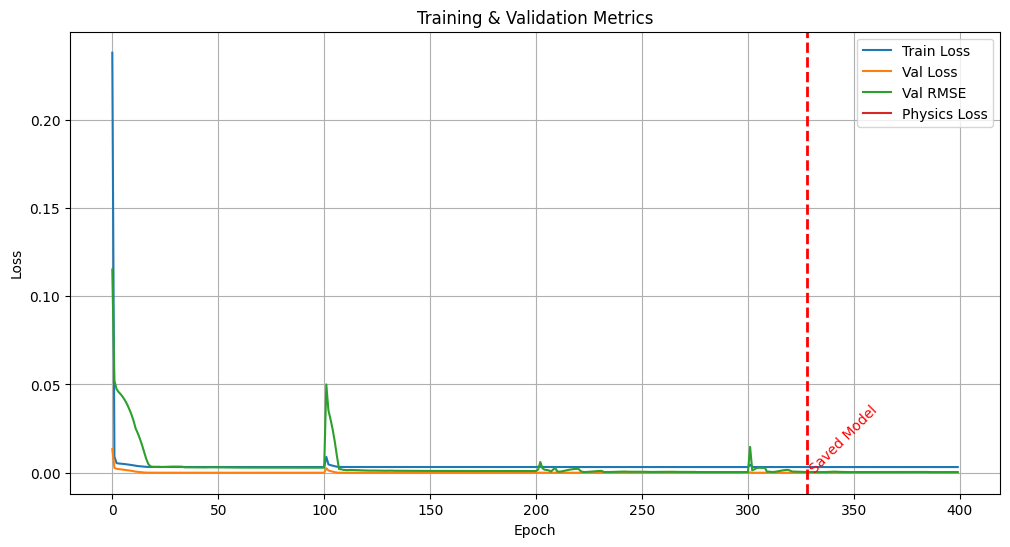

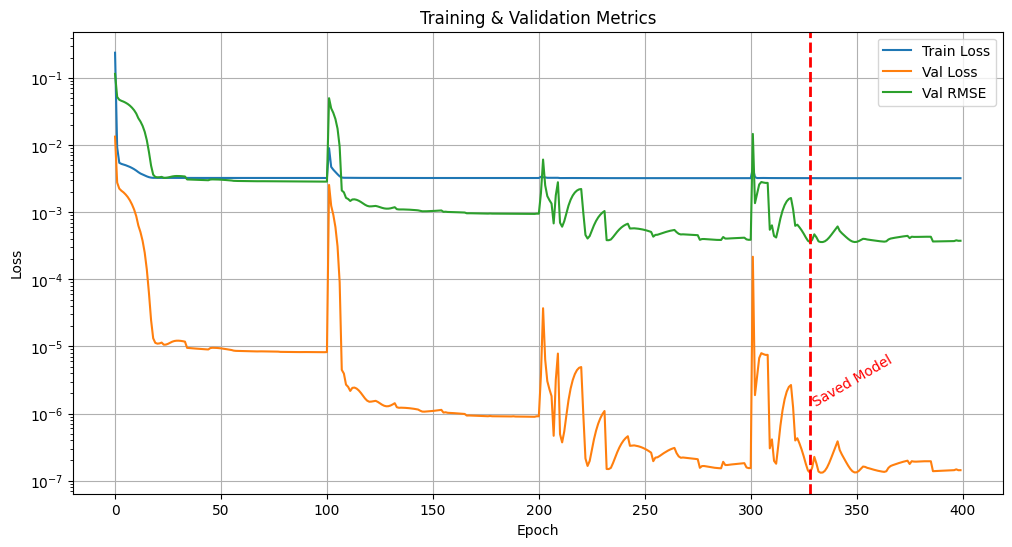

In [4]:
for WINDOW_SIZE in WINDOW_SIZES:
    #OUTPUT_SIZE = WINDOW_SIZE
    print("## 🧠 Model")
    if model_type == 'lstm':
        model = LSTMModel(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE).to(device) # values for multioutput model
        last_model_path = f'last_model_window_{WINDOW_SIZE}_model_{model_type}.pth'
        print("Last model window : ",last_model_path)
    if model_type == 'seq2seq-lstm':
        model = Seq2SeqLSTM(INPUT_SIZE,64,32,OUTPUT_SIZE).to(device) # values from previously working tensorflow model # 1, 64, 8, 1 
        last_model_path = f'last_model_window_{WINDOW_SIZE}_model_{model_type}.pth'
        print("Last model window : ",last_model_path)
    
    #### PREPARE ALL DATA ####
    ### DONT RUN AS LOOP
    def give_paths_get_loaders(paths,data_type,shuffle=False):
        X_list, y_list = get_x_y_lists(paths)
    
        if INPUT_SIZE == 1:
            # Concatenate all X and y
            X_1,y_1 = torch.cat(X_list, dim=0).squeeze(-1),torch.cat(y_list, dim=0).view(-1,INPUT_SIZE)
        else:
            X_1,y_1 = torch.cat(X_list, dim=0).squeeze(2),torch.cat(y_list, dim=0).view(-1,INPUT_SIZE)
        
        print(f"X_{data_type} , y_{data_type} shapes : ",X_1.shape, y_1.shape)
        
        #DataLoader
        print("load : ")
        loader = DataLoader(TensorDataset(X_1, y_1), batch_size=3200, shuffle=shuffle)
        print(f"{data_type}loader lengths : ",loader.__len__())
        return loader,X_1,y_1
    
    data_use = {
        0:["train"],1:["val"],2:["test"]
    }
    train_loader,X_train,y_train = give_paths_get_loaders(train_paths,data_use[0],shuffle=False)
    val_loader,X_val,y_val= give_paths_get_loaders(val_paths,data_use[1])
    test_loader,X_test,y_test = give_paths_get_loaders(test_paths,data_use[2])
    
    print('''##
    ### 📈 Gompertz Function (Physics Law)
    
    * `x`: Time (or cycle number)
    
    * `k`: Max value (e.g., max capacity)
    
    * `a`, `b`: Shape parameters''')
    
    def gompertz_func(x, k, a, b):
        return k * torch.exp(-a * torch.exp(-b * x))
    
    print("## 🧠 Loss Functions\n")
    
    print('''## ⚙️ 1. Data-Informed Loss Function
    a data loss (what the LSTM learns from data)
    
    * Mean Squared Error for Training
    * RMSE for autoregressive approximation of compound error
    
    ## ⚙️ 2. Physics-Informed Loss Function
    You combine a data loss (what the LSTM learns from data) and a physics loss (how well it conforms to Gompertz).
    
    * `alpha`: controls how strongly physics is enforced.''')
        
    def pinn_loss(prediction, target, x, k, a, b, alpha=1.0):
        data_loss = F.mse_loss(prediction, target)
        physics_pred = gompertz_func(x, k, a, b) #this needs to be refined !!!
        physics_loss = F.mse_loss(prediction, physics_pred)
        return data_loss + alpha * physics_loss, data_loss.item(), physics_loss.item()
    
    def data_loss_func(prediction, target, x, k, a, b, alpha=1.0):
        data_loss = F.mse_loss(prediction, target)
        return data_loss, data_loss.item() , None
    
    def physics_loss(prediction, target, x, k, a, b, alpha=1.0):
        #data_loss = F.mse_loss(prediction, target)
        physics_pred = gompertz_func(x, k, a, b) #this needs to be refined !!!
        physics_loss = F.mse_loss(prediction, physics_pred)
        return alpha * physics_loss, physics_loss.item(), None
    
    epoch = 0
    avg_train_loss = 0.0
    avg_val_loss = 0.0
    data_loss = 0.0
    phys_loss = None  # Only set if you're using physics loss
    
    if mode == 0:
        criterion = physics_loss #??
        best_model_path = f'best_pysics_model-window-{WINDOW_SIZE}.pth' #??
        loss_string = f"Epoch {epoch+1} | Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Data={data_loss:.4f} | Physics={phys_loss:.4f}"
    if mode == 1:
        criterion = data_loss_func
        best_model_path = f'best_lstm_model-window-{WINDOW_SIZE}.pth'
        loss_string = f"Epoch {epoch+1} | Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Data={data_loss:.4f}"
    if mode == 2:
        # phys_loss = 0.0 # Only set if you're using physics loss
        # criterion = pinn_loss
        # best_model_path = f'best_pinn_lstm_model-window-{WINDOW_SIZE}.pth'
        # loss_string = f"Epoch {epoch+1} | Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Data={data_loss:.4f} | Physics={phys_loss:.4f}"
        criterion = data_loss_func
        best_model_path = f'best_lstm_model-window-{WINDOW_SIZE}.pth'
        loss_string = f"Epoch {epoch+1} | Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Data={data_loss:.4f}"
    
    print("## 🛠️ Parameter Strategy")
    
    k = nn.Parameter(torch.tensor(1.0))
    a = nn.Parameter(torch.tensor(0.1))
    b = nn.Parameter(torch.tensor(0.1))
    # Include in optimizer
    optimizer = torch.optim.Adam(list(model.parameters()) + [k, a, b], lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)#lr_scheduler.StepLR(optimizer, step_size=20)
    # Function to set a new LR
    def set_learning_rate(optimizer, new_lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
            print(f"✅ Learning Rate updated to {new_lr}")
    print("## 🔁 Training Loop")
    def compute_rmse(pred, target):
        return torch.sqrt(F.mse_loss(pred, target))
        
    train_losses = []
    val_losses = []
    val_rmses = []
    data_losses = []
    phys_losses = []
    
    best_val_loss = float('inf')
    best_epoch = 0
    
    # Provide as a train function
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_data_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            #Set computing environment
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            #Predict
            y_pred = model(X_batch)
    
            # Create x_seq for physics loss
            x_seq = torch.arange(WINDOW_SIZE, dtype=torch.float32).unsqueeze(0).repeat(X_batch.size(0), 1).to(X_batch.device)
    
            loss, data_loss, phys_loss = criterion(y_pred, y_batch, x_seq, k, a, b, alpha=0.2)
            loss.backward()
            optimizer.step()
            total_data_loss += data_loss#.item() #TRY
            total_loss += loss.item()
        
        # Adjust learning rate
        scheduler.step(avg_val_loss)
        avg_data_loss = total_data_loss / len(train_loader)
        avg_train_loss = total_loss / len(train_loader)
        if epoch%100==0:
            #Reset LR 
            # Bump LR back up to 1e-3 to help it learn the new difficult task
            set_learning_rate(optimizer, 1e-3)
        # ---- Validation Pass ----
        model.eval()
        val_loss_total = 0.0
        val_rmse = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                #Set computing environment
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                #Predict
                y_val_pred = model(X_val_batch)
    
                #ADD A METRIC
                val_rmse += compute_rmse(y_val_pred, y_val_batch)
                
                x_seq_val = torch.arange(WINDOW_SIZE, dtype=torch.float32).unsqueeze(0).repeat(X_val_batch.size(0), 1).to(X_val_batch.device)
                val_loss, _, _ = criterion(y_val_pred, y_val_batch, x_seq_val, k, a, b, alpha=0.2)
    
                val_loss_total += val_loss.item()
    
        avg_val_loss = val_loss_total / len(val_loader)
        avg_val_rmse = val_rmse / len(val_loader)
        # Save model if validation improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), best_model_path)
            print(f"✅ Saved best model at epoch {epoch+1} (Val Loss = {best_val_loss:.8f})")
        if epoch+1 == num_epochs:
            torch.save(model.state_dict(),last_model_path)
            print(f"✅ Saved last model at epoch {epoch+1} ")
    
    
        if mode == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={avg_train_loss:.8f} | Val Loss={avg_val_loss:.8f} | Data={avg_data_loss:.8f} | Physics={phys_loss:.8f} | Val RMSE: {avg_val_rmse.item():.8f}")
        if mode == 1:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={avg_train_loss:.8f} | Val Loss={avg_val_loss:.8f} | Data={avg_data_loss:.8f} | Val RMSE: {avg_val_rmse.item():.8f} | √(Val Loss) = {torch.sqrt(torch.tensor(avg_val_loss)):.8f}")
        if mode == 2:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={avg_train_loss:.8f} | Val Loss={avg_val_loss:.8f} | Data={avg_data_loss:.8f} | Val RMSE: {avg_val_rmse.item():.8f} | √(Val Loss) = {torch.sqrt(torch.tensor(avg_val_loss)):.8f}")
            #print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={avg_train_loss:.8f} | Val Loss={avg_val_loss:.8f} | Data={avg_data_loss:.8f} | Physics={phys_loss:.8f} | Val RMSE: {avg_val_rmse.item():.8f}")
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_rmses.append(avg_val_rmse.item())  # assuming avg_val_rmse is a tensor
        data_losses.append(avg_data_loss)   # assuming this is the last batch's data loss
        phys_losses.append(phys_loss)   # assuming this is the last batch's physics loss
    
    model.load_state_dict(torch.load(best_model_path))
    
    np.savez(f"training_metrics__window_{WINDOW_SIZE}_model_{model_type}.npz",
             train_losses=train_losses,
             val_losses=val_losses,
             val_rmses=val_rmses,
             data_losses=data_losses,
             phys_losses=phys_losses)
    print("Plot losses after training 3:")
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses[3:], label="Train Loss")
    plt.plot(val_losses[3:], label="Val Loss")
    plt.plot(val_rmses[3:], label="Val RMSE")
    #plt.plot(data_losses[3:], label="Data Loss")
    plt.plot(phys_losses[3:], label="Physics Loss")
    x_line = best_epoch 
    plt.axvline(x=x_line, color='red', linestyle='--', linewidth=2)
    plt.text(x_line + 0.05, best_val_loss, 'Saved Model', rotation=45, color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Metrics")
    plt.grid(True)
    plt.savefig(fname = f"history-from-3-window_{WINDOW_SIZE}_model_{model_type}.png",dpi=300)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.plot(val_rmses, label="Val RMSE")
    #plt.plot(data_losses, label="Data Loss")
    plt.plot(phys_losses, label="Physics Loss")
    plt.axvline(x=x_line, color='red', linestyle='--', linewidth=2)
    plt.text(x_line + 0.05, best_val_loss, 'Saved Model', rotation=45, color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Metrics")
    plt.grid(True)
    plt.savefig(fname = f"history-full-window_{WINDOW_SIZE}_model_{model_type}.png",dpi=300)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.plot(val_rmses, label="Val RMSE")
    #plt.plot(data_losses, label="Data Loss")
    #plt.plot(phys_losses, label="Physics Loss")
    plt.axvline(x=x_line, color='red', linestyle='--', linewidth=2)
    plt.text(x_line, best_val_loss*10, 'Saved Model', rotation=30, color='red')
    plt.yscale('log')  # visualize on log scale
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Metrics")
    plt.grid(True)
    plt.savefig(fname = f"history-full-log-window_{WINDOW_SIZE}_model_{model_type}.png",dpi=300)
    plt.show()

In [5]:
model(X_batch)

tensor([[0.9504],
        [0.9503],
        [0.9502],
        ...,
        [0.7097],
        [0.7094],
        [0.7090]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [6]:
X_batch.shape

torch.Size([3139, 100, 1])

In [7]:
X_batch

tensor([[[0.9579],
         [0.9579],
         [0.9579],
         ...,
         [0.9507],
         [0.9502],
         [0.9502]],

        [[0.9579],
         [0.9579],
         [0.9579],
         ...,
         [0.9502],
         [0.9502],
         [0.9502]],

        [[0.9579],
         [0.9579],
         [0.9579],
         ...,
         [0.9502],
         [0.9502],
         [0.9502]],

        ...,

        [[0.7433],
         [0.7428],
         [0.7433],
         ...,
         [0.7099],
         [0.7095],
         [0.7092]],

        [[0.7428],
         [0.7433],
         [0.7423],
         ...,
         [0.7095],
         [0.7092],
         [0.7085]],

        [[0.7433],
         [0.7423],
         [0.7419],
         ...,
         [0.7092],
         [0.7085],
         [0.7080]]], device='cuda:0')

In [11]:
# !pip install sklearn

In [12]:
from sklearn.metrics import mean_squared_error
test_rmse = 0
for X_test, y_test in test_loader:
    X_test = X_test.to(device)
    y_pred = model(X_test)
    #print(y_pred,'\n',y_test)
    #inference for test results
    test_rmse += np.sqrt(mean_squared_error(y_test, y_pred.cpu().detach().numpy()))

print('\n Test RMSE for SoH to SoH prediction : ',test_rmse/len(test_loader))


 Test RMSE for SoH to SoH prediction :  0.0003713609039550647


In [13]:
all_step_predictions = []
current_window = X_test.clone() # Start with the initial X from loader

# Number of steps you want to forecast into the future
forecast_steps = 3000 

for _ in range(forecast_steps):
    # 1. Get prediction for current window
    # y_pred shape: [Batch, 1] (Next Capacity)
    y_pred = model(current_window)
    
    # Store for evaluation
    all_step_predictions.append(y_pred.detach())

    # 2. UPDATE ALL BATCHES AT ONCE
    # Assuming the value you append is the 1st column of your prediction
    # or the only column if predicting capacity directly.
    next_val = y_pred[:, 0:1].unsqueeze(1) # Shape: [Batch, 1, 1]
    
    # Drop index 0, append new value to end
    current_window = torch.cat((current_window[:, 1:, :], next_val.detach()), dim=1)

# Now current_window is updated for the next iteration

In [14]:
all_step_predictions[-1]

tensor([[0.6778],
        [0.6778],
        [0.6778],
        ...,
        [0.6778],
        [0.6778],
        [0.6778]], device='cuda:0')

In [20]:
X_test[0]

tensor([[0.9419],
        [0.9414],
        [0.9415],
        [0.9415],
        [0.9410],
        [0.9415],
        [0.9415],
        [0.9412],
        [0.9410],
        [0.9410],
        [0.9410],
        [0.9410],
        [0.9410],
        [0.9409],
        [0.9410],
        [0.9409],
        [0.9409],
        [0.9404],
        [0.9409],
        [0.9404],
        [0.9404],
        [0.9405],
        [0.9405],
        [0.9405],
        [0.9400],
        [0.9400],
        [0.9400],
        [0.9408],
        [0.9400],
        [0.9393],
        [0.9395],
        [0.9398],
        [0.9395],
        [0.9395],
        [0.9395],
        [0.9395],
        [0.9395],
        [0.9395],
        [0.9395],
        [0.9395],
        [0.9390],
        [0.9390],
        [0.9393],
        [0.9390],
        [0.9391],
        [0.9391],
        [0.9386],
        [0.9386],
        [0.9386],
        [0.9386],
        [0.9386],
        [0.9391],
        [0.9386],
        [0.9386],
        [0.9381],
        [0

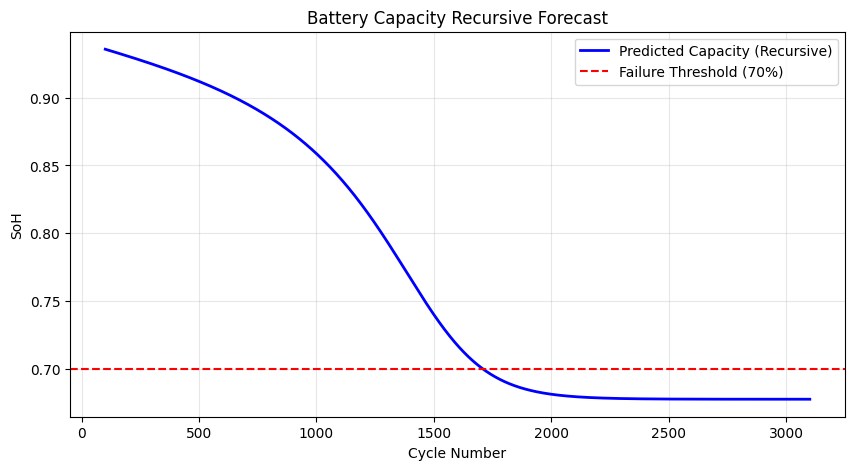

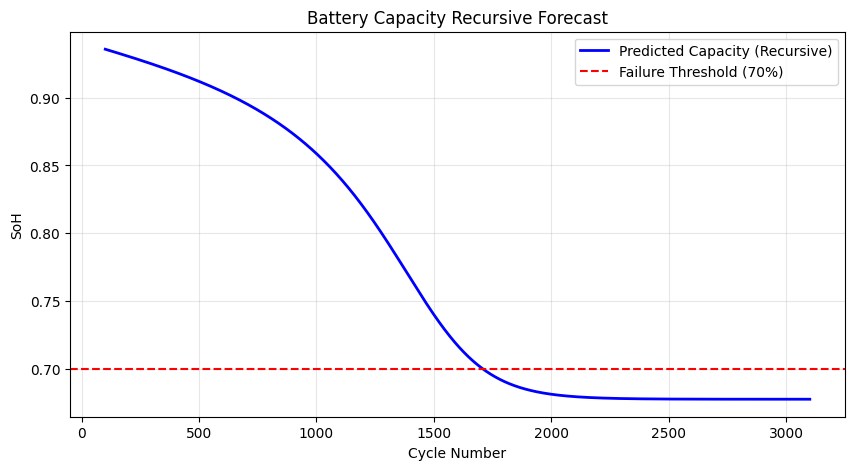

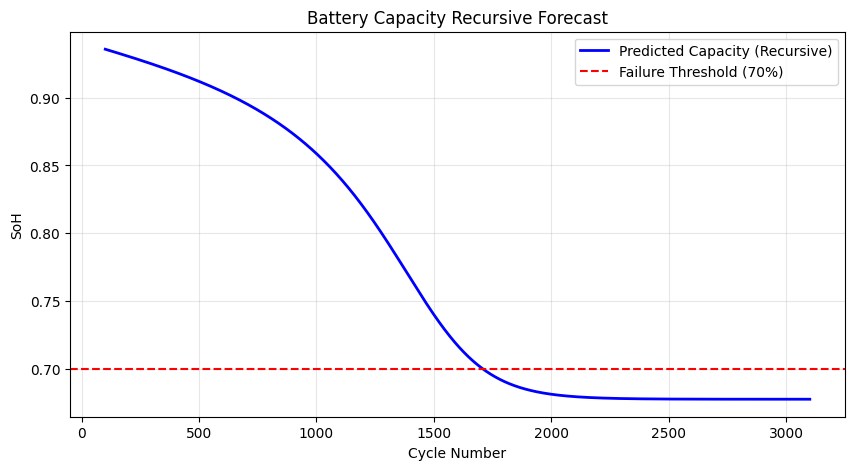

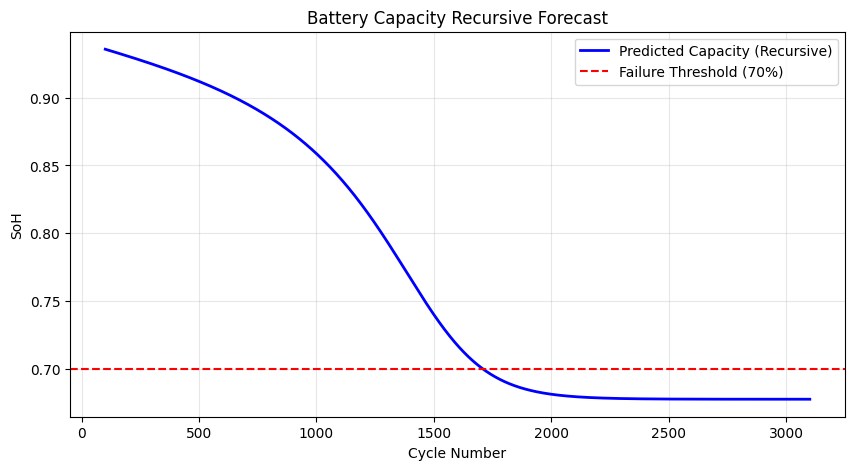

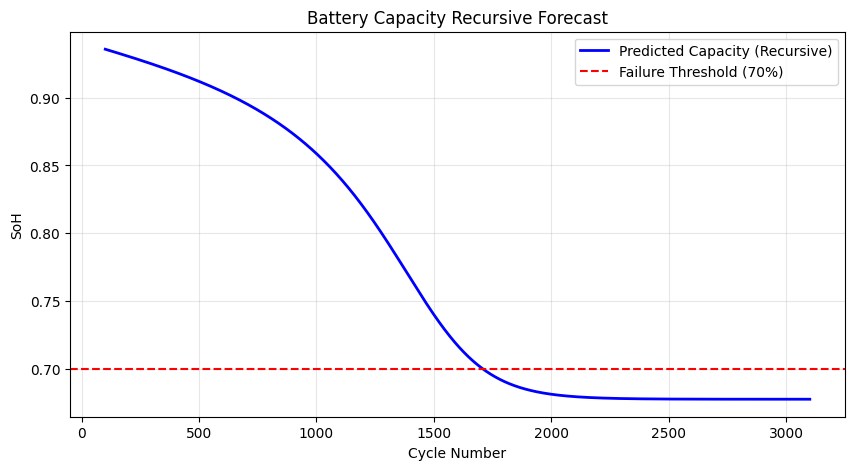

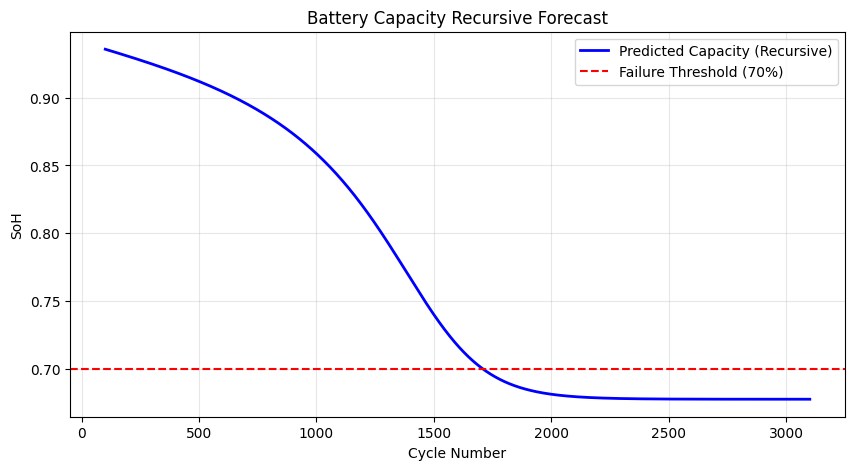

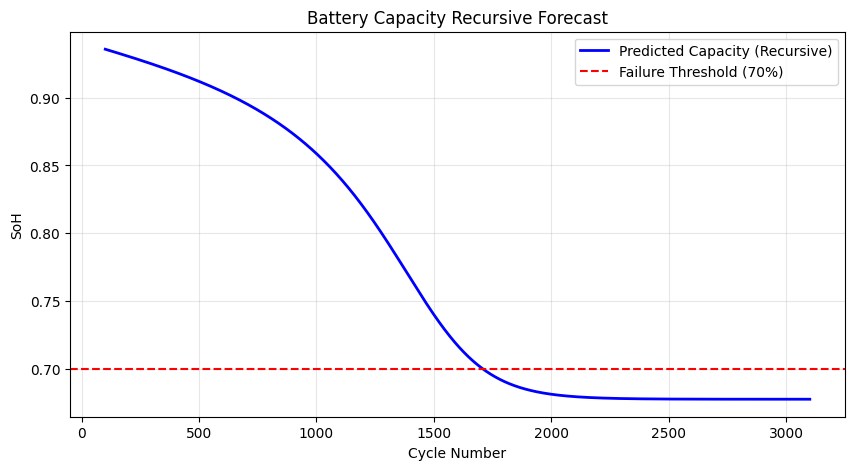

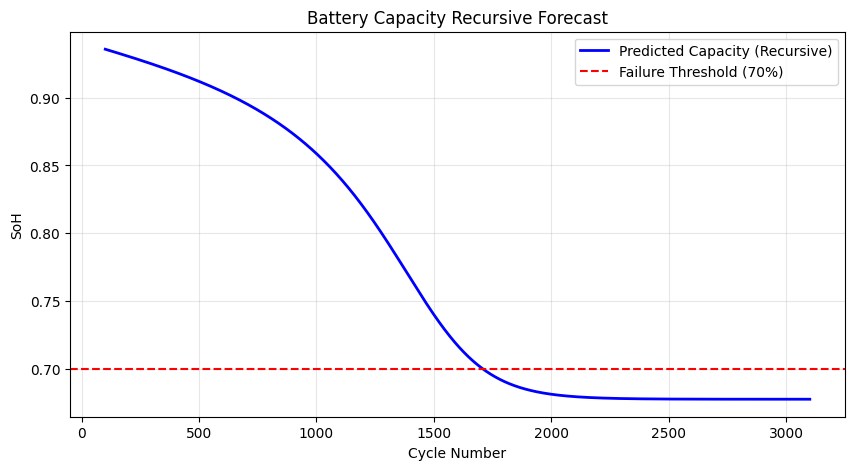

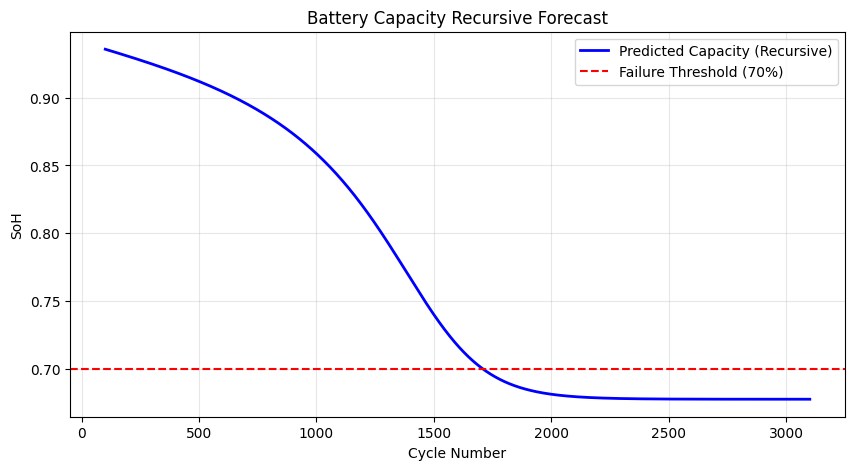

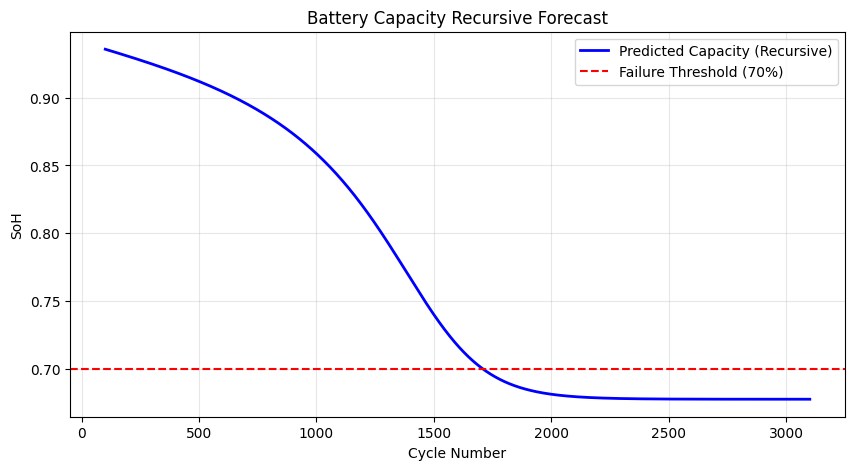

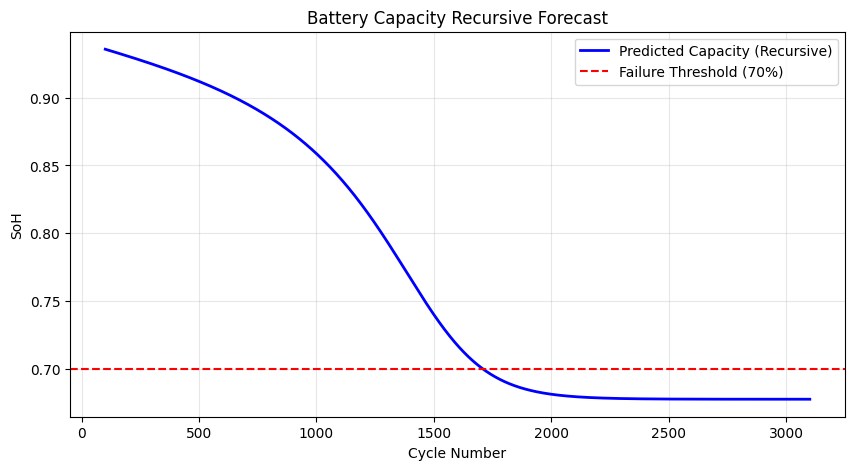

In [19]:
# 1. Stack the list into a single tensor: [Steps, Batch, 4]
all_preds_tensor = torch.stack(all_step_predictions) 

# 2. Extract the 1st feature (Capacity) for the 1st battery in the batch (Index 0)
# Shape will be [Steps]
for i in range(0,11):
    first_battery_forecast = all_preds_tensor[:, 1, 0].cpu().numpy()
    
    # 3. Create a time/cycle axis for the forecast
    start_cycle = 101 # Assuming your window was 100
    cycles = range(start_cycle, start_cycle + len(first_battery_forecast))
    
    # 4. Plot
    plt.figure(figsize=(10, 5))
    plt.plot(cycles, first_battery_forecast, label='Predicted Capacity (Recursive)', color='blue', linewidth=2)
    plt.axhline(y=0.7, color='red', linestyle='--', label='Failure Threshold (70%)')
    
    plt.title('Battery Capacity Recursive Forecast')
    plt.xlabel('Cycle Number')
    plt.ylabel('SoH')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()